## Utility functions


In [1]:
%matplotlib inline
from nltk.cluster.kmeans import KMeansClusterer
import nltk
import pickle

import torch
from pytorch_pretrained_bert import BertTokenizer, BertConfig, BertModel
from pytorch_pretrained_bert.modeling import BertPreTrainedModel, BertPreTrainingHeads
import numpy as np
from scipy.spatial.distance import cosine
import pickle
import re
import pandas as pd
device = 'cpu'
import sys
import os

import json


In [2]:
class BertForPreTraining_custom(BertPreTrainedModel):
    def __init__(self, config):
        super(BertForPreTraining_custom, self).__init__(config)
        self.bert = BertModel(config)
        self.cls = BertPreTrainingHeads(config, self.bert.embeddings.word_embeddings.weight)
        self.apply(self.init_bert_weights)

    def forward(self, input_ids, token_type_ids=None, attention_mask=None, masked_lm_labels=None, next_sentence_label=None):
        output_all_encoded_layers=True
        sequence_output, pooled_output = self.bert(input_ids, token_type_ids, attention_mask,
                                                   output_all_encoded_layers=output_all_encoded_layers)
        if output_all_encoded_layers:
            sequence_output_pred = sequence_output[-1]
        prediction_scores, seq_relationship_score = self.cls(sequence_output_pred, pooled_output)
        return prediction_scores, seq_relationship_score, sequence_output, pooled_output 
    
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
config = BertConfig.from_json_file('../data/bert_config.json')
bert_model = 'bert-base-uncased'

In [3]:
def getNSPScore(sample_text):
    
    m = torch.nn.Softmax()

    tokenized_text = tokenizer.tokenize(sample_text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

    segments_ids = [0]*tokenized_text.index('[SEP]')+[1]*(len(tokenized_text)-tokenized_text.index('[SEP]'))

    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])

    pred_score, seq_rel, seq_out, pool_out = model1(tokens_tensor, segments_tensors)
    return m(seq_rel).detach().numpy()[0][0] #returns probability of being next sentence

def getSentMatchScore(sent1, sent2, nsp_dampening_factor = 0.7):
    
    sent1_feats = getBERTFeatures(model1, sent1, attn_head_idx)
    sent2_feats = getBERTFeatures(model1, sent2, attn_head_idx)
    
    cosine_distance = 1- cosine(sent1_feats, sent2_feats)
    
    nsp_input1 = sent1+' [SEP] '+sent2
    nsp_input2 = sent2+' [SEP] '+sent1
    
    nsp_score_1 = getNSPScore(nsp_input1)
    nsp_score_2 = getNSPScore(nsp_input2)
    nsp_score = np.mean([nsp_score_1,nsp_score_2])*nsp_dampening_factor
    
    len_diff = abs(len(sent1.split(' '))-len(sent2.split(' ')))
    if len_diff>2*(min(len(sent1.split(' ')),len(sent2.split(' ')))):
        #give more weight to nsp if the sentences of largely varying lengths
        score = 0.4*cosine_distance+0.6*nsp_score
    else:
        score = np.mean([cosine_distance,nsp_score])
    
    #print ("nsp score -> " + str(nsp_score))
    #print ("cosine score -> " + str(cosine_distance))
    return score
    

def getSentMatchScore_wfeature(sent1, sent2, sent1_feats, sent2_feats, nsp_dampening_factor = 0.7):
    cosine_distance = 1-cosine(sent1_feats, sent2_feats)
    
    #return cosine_distance
    nsp_input1 = sent1+' [SEP] '+sent2
    #nsp_input2 = sent2+' [SEP] '+sent1
    
    nsp_score_1 = getNSPScore(nsp_input1)
    #nsp_score_2 = getNSPScore(nsp_input2)
    
    nsp_score = nsp_score_1 * nsp_dampening_factor
    #nsp_score = nsp_score_1*nsp_dampening_factor
    
    len_diff = abs(len(sent1.split(' '))-len(sent2.split(' ')))
    if len_diff>2*(min(len(sent1.split(' ')),len(sent2.split(' ')))):
        #give more weight to nsp if the sentences of largely varying lengths
        score = 0.4*cosine_distance+0.6*nsp_score
    else:
        score = np.mean([cosine_distance,nsp_score])
    
    return score

def getSentMatchScore_wfeature_cosine(sent1, sent2, sent1_feats, sent2_feats, nsp_dampening_factor = 0.7):
    cosine_distance = 1-cosine(sent1_feats, sent2_feats)
    
    return cosine_distance
    

def getSentMatchScore_wfeature_test(sent1, sent2, sent1_feats, sent2_feats, nsp_dampening_factor = 0.7):
    cosine_distance = 1-cosine(sent1_feats, sent2_feats)
    
    nsp_input1 = sent1+' [SEP] '+sent2
    nsp_input2 = sent2+' [SEP] '+sent1
    
    nsp_score_1 = getNSPScore(nsp_input1)
    nsp_score_2 = getNSPScore(nsp_input2)
    
    nsp_score = np.mean([nsp_score_1,nsp_score_2])*nsp_dampening_factor
    #nsp_score = nsp_score_1*nsp_dampening_factor
    
    len_diff = abs(len(sent1.split(' '))-len(sent2.split(' ')))
    if len_diff>2*(min(len(sent1.split(' ')),len(sent2.split(' ')))):
        #give more weight to nsp if the sentences of largely varying lengths
        score = 0.4*cosine_distance+0.6*nsp_score
    else:
        score = np.mean([cosine_distance,nsp_score])
    
    return score, cosine_distance, nsp_score
def getBERTFeatures(model, text, attn_head_idx = -1): #attn_head_idx - index o[]
    tokenized_text = tokenizer.tokenize(text)
    if len(tokenized_text)>200:
        tokenized_text = tokenized_text[0:200]
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    tokens_tensor = torch.tensor([indexed_tokens])
    _, _, seq_out, pool_out = model(tokens_tensor)
    seq_out = list(getPooledFeatures(seq_out[attn_head_idx]).T)
    #pool_out = list(pool_out.detach().numpy().T)
    
    return seq_out

def getPooledFeatures(np_array):
    np_array = np_array.reshape(np_array.shape[1],np_array.shape[2]).detach().numpy()
    np_array_mp = np.mean(np_array, axis=0).reshape(1, -1)
    return np_array_mp

def replaceContractions(text):
    #text = text.lower()
    c_filt_text = ''
    for word in text.split(' '):
        if word in contractions:
            c_filt_text = c_filt_text+' '+contractions[word]
        else:
            c_filt_text = c_filt_text+' '+word
    return c_filt_text

def cleanText(text):
        
    text = text.replace('\\n','')
    text = text.replace('\\','')
    #text = text.replace('\t', '')
    #text = re.sub('\[(.*?)\]','',text) #removes [this one]
    text = re.sub('(http:\/\/www\.|https:\/\/www\.|http:\/\/|https:\/\/)?[a-z0-9]+([\-\.]{1}[a-z0-9]+)*\.[a-z]{2,5}(:[0-9]{1,5})?(\/.*)?\s',
                ' __url__ ',text) #remove urls
    #text = re.sub('\'','',text)
    #text = re.sub(r'\d+', ' __number__ ', text) #replaces numbers
    text = re.sub('\W', ' ', text)
    text = re.sub(' +', ' ', text)
    text = text.replace('\t', '')
    text = text.replace('\n', '')
    return text

In [4]:
model1 = BertForPreTraining_custom(config)
model1.to(device)
#state_dict_1 = torch.load('/home/ether/domain_mind/ai/bert_10epc_ai_ds_1e-6_sl40.bin')
state_dict_1 = torch.load('../data/bert_10epc_se_1e-6_sl40.bin')
model1.load_state_dict(state_dict_1)
model1.eval()

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location='cpu' to map your storages to the CPU.

In [5]:
def parsemeeting(text):
    with open(text, 'r') as f:
        parsed_text = json.load(f)
    return parsed_text
text = parsemeeting('../data/meeting_transcript.txt')

In [6]:
texts = ''
for t in text['timeline']['transcriptSegments']:
    texts+= t['text']

In [8]:
texts

"Study and hey cabin class and other variables in order to book you write you interact with the airlines website to access the airline's database to see if any seats are available on those dates and what the cost might be based on certain variables. But what if you're not using the airlines website which has direct access to the information what if you are using an online Travel Service that Aggregates information from many different airlines the Travel Service interacts with the airline's API. The API is in a face that like your helpful where can be asked by that online Travel Service to get information from the airline system over the internet to book seats choose meal preferences for baggage options. It also then takes the airline's response to your request and delivers it right back to the online Travel Service, which then shows it to you. So now you can see that it's apis that make it possible for us all to use travel sites the same goes for all interactions between applications d

## get Communities from meetings.

In [11]:
import sys, pickle
sys.path.append('../')
import text_preprocessing.preprocess as tp

# with open('../data/Engineering_Mind_Test_Transcripts.txt','r') as fp:
#     texts = fp.read()

mod_texts_unfiltered = tp.preprocess(texts, stop_words=False, remove_punct=True)
mod_texts = []

for index, sent in enumerate(mod_texts_unfiltered):
    if len(sent.split(' '))>250:
        length = len(sent.split(' '))
        split1 = ' '.join([i for i in sent.split(' ')[:round(length/2)]])
        split2 = ' '.join([i for i in sent.split(' ')[round(length/2):]])
        mod_texts.append(split1)
        mod_texts.append(split2)
        continue
        #mod_texts.pop(index)
    if len(sent.split(' '))<=6:
        continue
    mod_texts.append(sent)

print(len(mod_texts))
fv = {}

for index, sent in enumerate(mod_texts):
    fv[index] = getBERTFeatures(model1, sent, attn_head_idx=-1)
    print (index)

153
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152


In [12]:
import networkx as nx

def build_graph(doc_list):
    eng_graph = nx.Graph()
    try:
        eng_graph.add_nodes_from(range(len(doc_list)))
    except Exception as e:
        print(e)
    return eng_graph


tg = build_graph(mod_texts)

In [13]:
attn_head_idx = -1

node_edge = []

for index1, sent1 in enumerate(mod_texts):
    print (index1)
    for index2, sent2 in enumerate(mod_texts):
        if index1!=index2:
            score = getSentMatchScore_wfeature(sent1, sent2,fv[index1],fv[index2])
#             if score > 0.8:
#                 #tg.add_edge(index1,index2,{'weight': score})
#                 tg.add_edge(index1,index2)
            tg.add_edge(index1,index2,weight=score)

0


/home/ray__/.local/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152


In [14]:
def build_community_graph(tg, mod_texts):
    com_graph = nx.Graph()
    for sent in list(tg.nodes()):
        com_graph.add_node(sent)
    for nodea in tg.nodes():
        for nodeb in tg.nodes():
            if nodea!=nodeb:
                if tg.edges[nodea,nodeb]['weight'] > 0.75:
                    com_graph.add_edge(nodea,nodeb)
    return com_graph
com_graph = build_community_graph(tg, mod_texts)

/home/ray__/.local/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


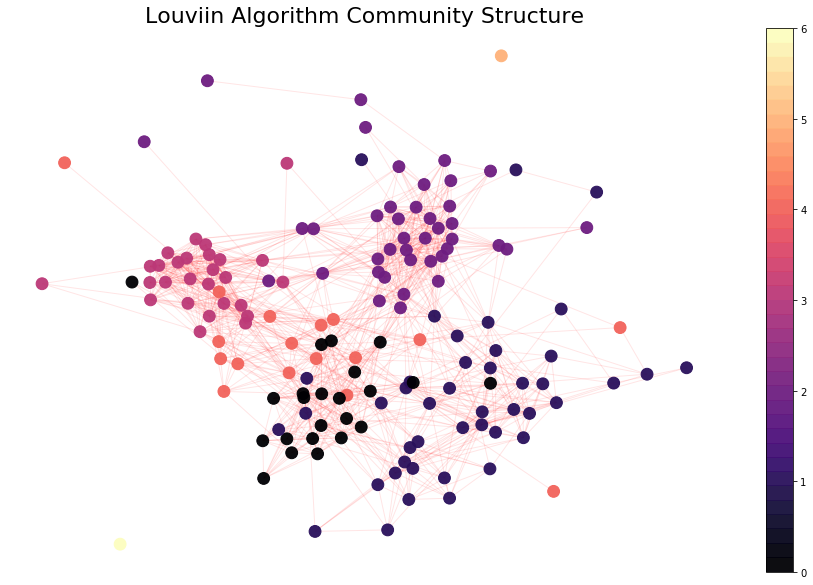

In [15]:
# import community
# import matplotlib.pyplot as plt
# partition = community.best_partition(tg)

# values = [partition.get(node) for node in tg.nodes()]
# values=[partition.get(node) for node in tg.nodes()]
# plt.rcParams['figure.figsize']= [16, 10]
# measure_name = "Louviin Algorithm Community Structure"
# pos = nx.spring_layout(tg, k=0.2, iterations=20)
# nodes_plot=nx.draw_networkx_nodes(tg, pos, node_size=140, label=True, cmap=plt.get_cmap('magma', len(tg.nodes())/4),node_color=values, alpha=0.95)
# edges_plot=nx.draw_networkx_edges(tg, pos, edge_color='r', alpha=0.1)
# plt.title(measure_name, fontsize=22, fontname='Arial')
# plt.colorbar(nodes_plot)
# plt.axis('off')
# plt.show()

import community
import matplotlib.pyplot as plt
partition = community.best_partition(com_graph)

values = [partition.get(node) for node in com_graph.nodes()]
values=[partition.get(node) for node in com_graph.nodes()]
plt.rcParams['figure.figsize']= [16, 10]
measure_name = "Louviin Algorithm Community Structure"
pos = nx.spring_layout(com_graph, k=0.2, iterations=20)
nodes_plot=nx.draw_networkx_nodes(com_graph, pos, node_size=140, label=True, cmap=plt.get_cmap('magma', len(com_graph.nodes())/4),node_color=values, alpha=0.95)
edges_plot=nx.draw_networkx_edges(com_graph, pos, edge_color='r', alpha=0.1)
plt.title(measure_name, fontsize=22, fontname='Arial')
plt.colorbar(nodes_plot)
plt.axis('off')
plt.show()

In [16]:
community.modularity(partition, com_graph)

0.5655021313025556

In [17]:
partition = sorted(partition.items(), key=lambda kv: kv[1], reverse=False)

In [18]:
current = 0
print ("--------------cluster " + str(0) + "------------ \n ")
for word, cluster in partition:
    if cluster!=current:
        print ("--------------cluster " + str(cluster) + "------------ \n ")
        print (mod_texts[word])
        current=cluster
    else:
        print (mod_texts[word])

--------------cluster 0------------ 
 
Study and hey cabin class and other variables in order to book you write you interact with the airlines website to access the airline is database to see if any seats are available on those dates and what the cost might be based on certain variables.
But what if you are not using the airlines website which has direct access to the information what if you are using an online Travel Service that Aggregates information from many different airlines the Travel Service interacts with the airline is API.
The API is in a face that like your helpful where can be asked by that online Travel Service to get information from the airline system over the internet to book seats choose meal preferences for baggage options.
It also then takes the airline is response to your request and delivers it right back to the online Travel Service which then shows it to you.
So now you can see that it is apis that make it possible for us all to use travel sites the same goes f

In [35]:
com_graph.number_of_edges()

132

In [36]:
tg.number_of_edges()

11628

In [54]:
clusters = []
temp = []
tot_com = 12
prev_com = 0
for word,cluster in partition:
    if prev_com!=cluster:
        clusters.append(temp)
        temp = []
        prev_com+=1
    else:
        temp.append(word)

In [95]:
clusters

[[0, 4, 31, 42, 43, 48, 49, 55],
 [2,
  3,
  5,
  6,
  7,
  8,
  9,
  10,
  12,
  13,
  14,
  17,
  18,
  19,
  28,
  30,
  32,
  33,
  35,
  45,
  51,
  52,
  54,
  56,
  57,
  58,
  59,
  60,
  61,
  66,
  67],
 [],
 [22, 24, 25, 26, 27, 36, 37, 38, 40, 41, 44, 68, 70, 71, 75],
 [20,
  21,
  23,
  29,
  46,
  47,
  50,
  53,
  72,
  73,
  74,
  77,
  116,
  119,
  128,
  129,
  130,
  131,
  132,
  133,
  136,
  137,
  138,
  139],
 [78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  110,
  111,
  112,
  113,
  114,
  115],
 [141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  154,
  155,
  156,
  157,
  158,
  159],
 [69,
  117,
  118,
  120,
  121,
  122,
  127,
  134,
  135,
  140,
  160,
  161,
  162,
  163,
  164,
  165],
 [64, 65, 123, 124, 125, 126],
 [],
 [94, 95, 96, 97],
 []]

In [55]:
new_text = []
temp = ""
for com in clusters:
    new_text.append(' '.join(mod_texts[sent] for sent in com))

In [ ]:
new_text[11]

## Using communities build word graph

In [96]:
from graphrank.graphrank import GraphRank
from graphrank.utils import GraphUtils, TextPreprocess

gr = GraphRank()
tp = TextPreprocess()
utils = GraphUtils()


In [97]:
keyphrases_list = []
for index, com in enumerate(new_text):
    if com!="":
        gr = GraphRank()
        tp = TextPreprocess()
        utils = GraphUtils()

        original_tokens, pos_tuple, filtered_pos_tuple = tp.preprocess_text(com, filter_by_pos=True, pos_filter=['NOUN', 'PROPN', 'ADJ', 'FW'], stop_words=False)

        word_graph = gr.build_word_graph(filtered_pos_tuple, original_tokens=original_tokens, window=4, reset_graph_context=True, preserve_common_words=False)

        keyphrases = gr.get_keyphrases(word_graph, normalize_nodes='degree', des)
        print (index, keyphrases[0])
        keyphrases_list.append(keyphrases)

0 ('good shape', 0.025274772430892507)
1 ('best continuation orchestration', 0.0043051054565250765)
3 ('cross domain cookie creations', 0.01031856452770605)
4 ('full text search', 0.009569841640831274)
5 ('overt racial tension frightening gang wars', 0.0037066389162053216)
6 ('distributed scalable big data store', 0.008502342399005833)
7 ('single binary distribution policy', 0.01443594875044727)
8 ('opencv python webrtc apps', 0.01564966573381657)
10 ('pok sino indian ties', 0.022361965890997877)


In [173]:
for index, com in enumerate(keyphrases_list):
    print ("--------------Community-----------    " + str(index))
    for keyphrase in com:
        print (keyphrase[0])

--------------Community-----------    0
good shape
highest priority
ui changes
request yesterday
monday
tasks
timeline
perspective
ready
nats
performance
shivam
--------------Community-----------    1
best continuation orchestration
basic slack install flow
unique work space installation
extra bucket private
initial production level
proper regression testing
key phrase extraction
customer provision method
channel mind scheme
corner cases
manual peak
ecxnumberx ebs
peak kind
hamburger menu
context instance
local storage
installation process
cdn distribution
simple kind
github pr
custom url
short time
website front
independent connectors
api contract
basic white
cdn bucket
service methods
developer sign
regression tests
current database
reply pattern
regular key
internal service
channel list
sxnumberx bucket
admin table
api contracts
specific requirement
current approaches
customers table
admin flow
key phrase
second pass
current focus
nats message
current production
customer service
rea

## testing topic modelling with LDA

In [148]:
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string
stop = set(stopwords.words('english'))
exclude = set(string.punctuation) 
lemma = WordNetLemmatizer()
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

doc_clean = [clean(doc).split() for doc in new_text]
#doc_clean = [clean(new_text[1]).split()]

In [149]:
doc_clean

[['back',
  'end',
  'perspective',
  'ready',
  'integrate',
  'think',
  'good',
  'shape',
  'think',
  'shivam',
  'separate',
  'nats',
  'performance',
  'related',
  'change',
  'think',
  'need',
  'approve',
  'thing',
  'think',
  'one',
  'request',
  'yesterday',
  'highest',
  'priority',
  'first',
  'handle',
  'ui',
  'change',
  'working',
  'ui',
  'change',
  'timeline',
  'related',
  'task',
  'staging',
  'monday'],
 ['basically',
  'know',
  'basic',
  'slack',
  'install',
  'flow',
  'right',
  'simple',
  'kind',
  'login',
  'mean',
  'installation',
  'process',
  'take',
  'slack',
  'authenticates',
  'give',
  'necessary',
  'permission',
  'installs',
  'come',
  'back',
  'right',
  'back',
  'end',
  'information',
  'need',
  'ready',
  'go',
  'put',
  'page',
  'place',
  'right',
  'like',
  'kind',
  'corner',
  'case',
  'need',
  'regression',
  'test',
  'admin',
  'flow',
  'deploy',
  'production',
  'one',
  'thing',
  'need',
  'back',
  'f

In [155]:
import gensim
from gensim import corpora
dictionary = corpora.Dictionary(doc_clean)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

In [156]:
Lda = gensim.models.ldamodel.LdaModel
ldamodel = Lda(doc_term_matrix, num_topics=3, id2word = dictionary, passes=50)

In [157]:
print(ldamodel.print_topics())

[(0, '0.008*"zone" + 0.008*"hosted" + 0.008*"creation" + 0.008*"license" + 0.006*"one" + 0.006*"domain" + 0.005*"probably" + 0.005*"say" + 0.005*"thing" + 0.005*"never"'), (1, '0.018*"xnumberx" + 0.008*"data" + 0.007*"file" + 0.005*"task" + 0.005*"apple" + 0.005*"new" + 0.005*"time" + 0.005*"hbase" + 0.005*"hdfs" + 0.005*"hadoop"'), (2, '0.015*"like" + 0.015*"customer" + 0.011*"basically" + 0.008*"one" + 0.007*"service" + 0.007*"right" + 0.007*"know" + 0.007*"sign" + 0.007*"end" + 0.007*"thing"')]
